# CoV Classifier Test Metrics

Fig. 5A-C plots

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## summary stats table

In [2]:
def combine_stats(list_of_paths):
    # read all results files and combine
    df = pd.concat([pd.read_csv(path) for path in list_of_paths]).reset_index(drop=True)

    # get means and errors
    means = df.groupby("model_name").mean()
    sem = df.groupby("model_name").sem()

    # combine in a readable table format
    combined = means.copy()
    for i in means.index:
        for j in [col for col in means.columns if "test" in col]:
            combined.loc[i,j] = f"{str(round(means.loc[i,j], 4))} (\xB1 {str(round(sem.loc[i,j], 4))})"
            # combined.loc[i,j] = f"{str(round(means.loc[i,j]*100, 2))} (\xB1 {str(round(sem.loc[i,j]*100, 2))})"

    return combined

In [3]:
# replace with actual paths to summary results
combine_stats(["./results/uniform-250k_itr-tests_50ep_HD-CoV.csv", 
               "./results/uniform-350k_itr-tests_50ep_HD-CoV.csv",
               "./results/preferential-250k_itr-tests_50ep_HD-CoV.csv"])

,itr,test_loss,test_accuracy,test_precision,test_recall,test_f1,test_auc,test_aupr,test_mcc
model_name,,,,,,,,,
preferential-250k,2.0,0.5237 (± 0.0026),0.7372 (± 0.0021),0.7299 (± 0.0045),0.7535 (± 0.0045),0.7414 (± 0.0011),0.8167 (± 0.0017),0.8287 (± 0.0015),0.4748 (± 0.004)
uniform-250k,2.0,0.5335 (± 0.0035),0.7292 (± 0.0018),0.7101 (± 0.0034),0.7748 (± 0.0037),0.741 (± 0.0011),0.8131 (± 0.0021),0.8231 (± 0.0026),0.4604 (± 0.0034)
uniform-350k,2.0,0.5348 (± 0.0033),0.7293 (± 0.0025),0.7042 (± 0.004),0.7909 (± 0.004),0.745 (± 0.0015),0.8149 (± 0.0018),0.825 (± 0.0029),0.4622 (± 0.0045)


## classifier performance over training

test set eval data is exported from [weights and biases](wandb.ai) by downloading from the wandb project (with `x=train/epoch` and `y=eval/accuracy` or `y=eval/aupr`)

can also access through trainer logs `trainer.state.log_history` (if the trainer state is saved)

In [4]:
# for renaming the models from their job_id abbreviations in the column names
def model_name(col):
    if "preferential" in col:
        return "Preferential-250k"
    elif ("uniform" in col) and ("250k" in col):
        return "Uniform-250k"
    else:
        return "Uniform-350k"

model_order = ["Uniform-250k", "Uniform-350k", "Preferential-250k"]
color_order = [sns.color_palette("Set3")[4], sns.color_palette("Set3")[0], sns.color_palette("Set3")[5]]

In [5]:
# download test metrics data from wandb (or access via trainer logs) and replace with actual paths
acc = pd.read_csv("acc_CoV.csv")
acc = acc.iloc[:, [0] + list(range(4, acc.shape[1], 6))]

aupr = pd.read_csv("aupr_CoV.csv")
aupr = aupr.iloc[:, [0] + list(range(4, aupr.shape[1], 6))]

In [6]:
# pivot table for plotting
plot_data = []

for column in acc.iloc[:, 1:]:
    aupr_col = column.replace("accuracy", "aupr")
    model = model_name(column) 
    pivoted = list(zip(acc["train/epoch"], acc[column], aupr[aupr_col], [model]*len(acc["train/epoch"])))
    plot_data.extend(pivoted)

data = pd.DataFrame(plot_data, columns=["Epoch", "Accuracy", "AUPR", "Base Model"])
data

,Epoch,Accuracy,AUPR,Base Model
0,2,0.694172,0.774058,Uniform-350k
1,4,0.716403,0.800864,Uniform-350k
2,6,0.723813,0.812939,Uniform-350k
3,8,0.720409,0.817268,Uniform-350k
4,10,0.726016,0.820035,Uniform-350k
...,...,...,...,...
370,42,0.717861,0.814189,Uniform-250k
371,44,0.725871,0.815250,Uniform-250k
372,46,0.722467,0.814543,Uniform-250k
373,48,0.720064,0.815172,Uniform-250k


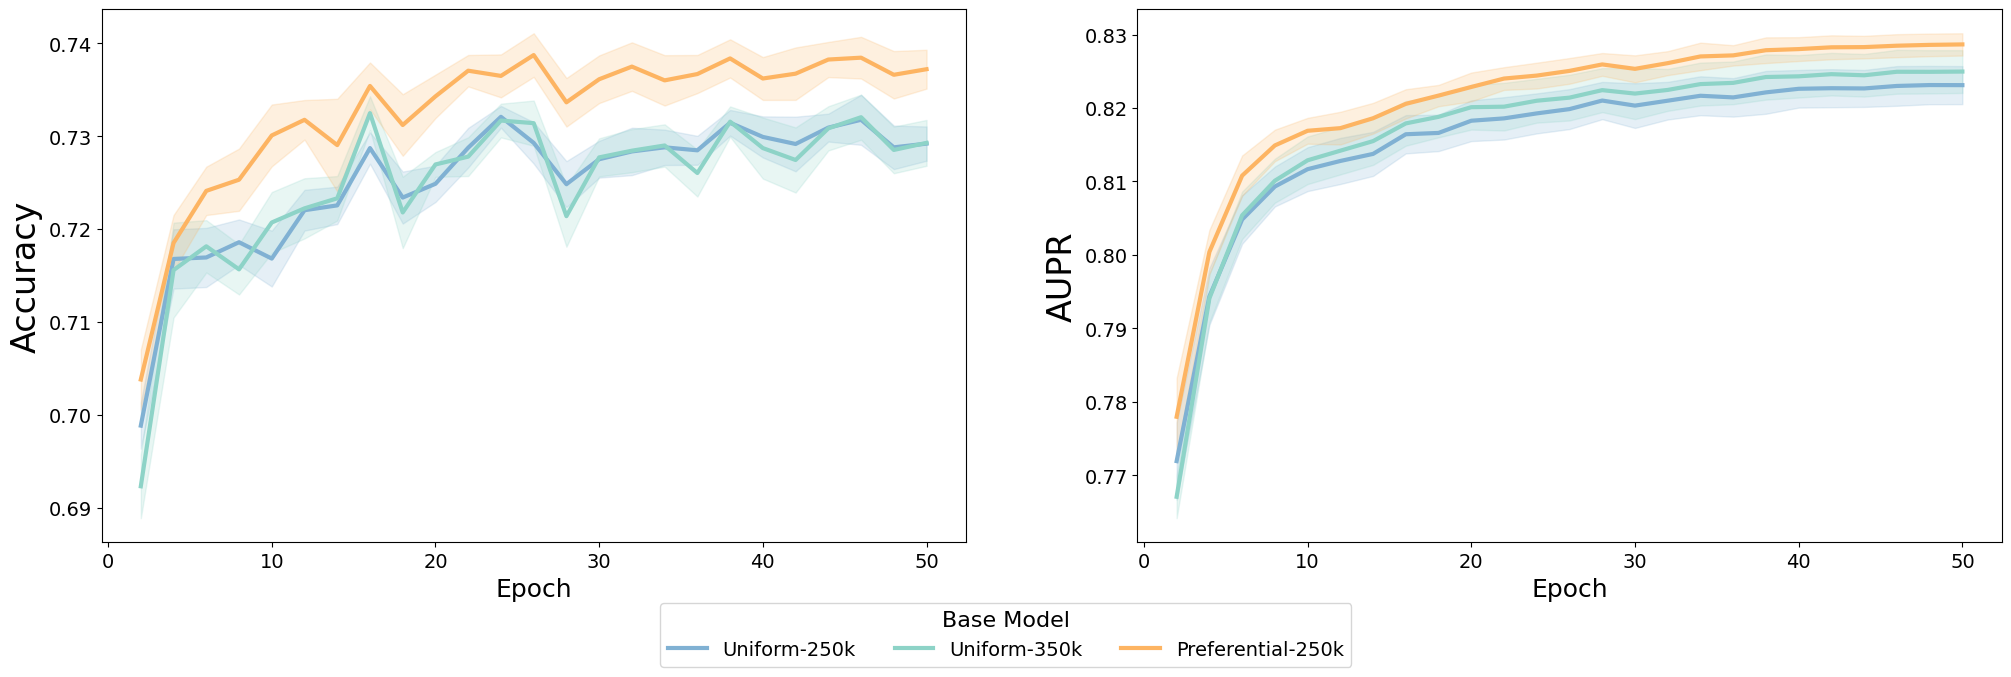

In [7]:
fig, ax = plt.subplot_mosaic([['a.', 'b.']],
                              layout='constrained',
                              figsize=(20, 6),
                              gridspec_kw={"wspace": 0.08, "hspace": 0.08},
                             )
plots = {
    "a.": "Accuracy",
    "b.": "AUPR",
}

for label, metric in plots.items():
    sns.lineplot(data=data, x="Epoch", y=metric, 
                 hue="Base Model", hue_order=model_order,
                 errorbar=("se"),
                 palette=color_order, 
                 linewidth=3,
                 ax=ax[label])
    # ax[label].legend(loc="lower right", fontsize=14, title_fontsize=16)
    ax[label].get_legend().set_visible(False)
    ax[label].set_xlabel("Epoch", fontsize=18)
    ax[label].set_ylabel(metric, fontsize=24)
    ax[label].xaxis.set_tick_params(labelsize = 14)
    ax[label].yaxis.set_tick_params(labelsize = 14)
    # ax[label].annotate(label, xy=(-0.1, 1.02), xycoords="axes fraction", 
    #                    fontsize=20, weight="bold")

# single legend for whole plot
handles, labels = ax["a."].get_legend_handles_labels()
fig.legend(handles, labels, 
           loc="center", 
           title="Base Model",
           bbox_to_anchor=(0.5, -0.05),
           fontsize=14, title_fontsize=16,
           ncols=3)

# plt.savefig("CoV_acc_aupr.svg", bbox_inches='tight')